# Machine Learning Group Project 

User game rating prediction & systematic discount offering on Steam. Project developed by Team XX composed by:
| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | XXXX | XX |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | XXXX | XX |
| **Yannick von der Heyden** | 53629 | TA |

## Importing Packages 

In [1]:
import ast
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import igraph as ig
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Reading DataFrame

In [2]:
final_df = pd.read_csv("data/final_df.csv")
final_df.head()

,app_id,helpful,funny,date,y,hours,user_id,review_id,title,date_release,...,publisher,required_age,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,products,reviews
0,304390,4,0,2017-02-17,False,11.5,1098,1,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,269,1
1,304390,2,0,2017-03-23,False,180.6,140776,26,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,110,2
2,108600,0,0,2022-01-17,False,132.2,140776,2349519,Project Zomboid,2013-11-08,...,The Indie Stone,0,Indie;RPG;Simulation;Early Access,Early Access;Survival;Zombies,0,658,701,500000-1000000,110,2
3,304390,0,0,2017-02-25,False,5.0,3904802,191,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,17,1
4,304390,4,0,2021-04-25,False,42.5,4222787,203,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,951,16


## Data Exploration

In [3]:
final_df.shape

(6564923, 35)

In [4]:
total_nans = final_df.isna().sum().sum()
print(f"Total NaNs in the final_df DataFrame: {total_nans}")

Total NaNs in the final_df DataFrame: 0


In [5]:
# describe final_df
final_df.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
app_id,6564923.0,333103.39,185197.05,70.0,49520.0,238960.00,294100.00,431960.00,594650.00,1032430.00
helpful,6564923.0,3.46,58.34,0.0,0.0,0.00,0.00,0.00,3.00,29627.00
funny,6564923.0,1.39,48.06,0.0,0.0,0.00,0.00,0.00,0.00,28088.00
hours,6564923.0,190.43,237.30,0.0,7.6,23.60,83.00,268.90,574.10,999.90
user_id,6564923.0,3004127.70,1650810.13,0.0,614340.0,1666029.00,3047610.00,4435053.00,5229131.00,5810792.00
review_id,6564923.0,5136968.74,2967648.97,1.0,1024397.2,2559700.00,5120629.00,7756637.50,9286506.60,10072269.00
positive_ratio,6564923.0,87.83,7.84,44.0,78.0,83.00,88.00,94.00,97.00,98.00
user_reviews,6564923.0,415855.42,1132509.05,174.0,21086.0,52226.00,105614.00,204840.00,722973.00,6941137.00
price_final,6564923.0,21.18,15.57,0.0,0.0,9.99,19.99,29.99,39.99,59.99
price_original,6564923.0,22.42,16.51,0.0,0.0,9.99,19.99,29.99,39.99,109.99


**Correlation Matrix**

C:\Users\Johannes Rahn\AppData\Local\Temp\ipykernel_30312\1089923943.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['rating'] = df_analyze['rating'].map(rating_map)
C:\Users\Johannes Rahn\AppData\Local\Temp\ipykernel_30312\1089923943.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})


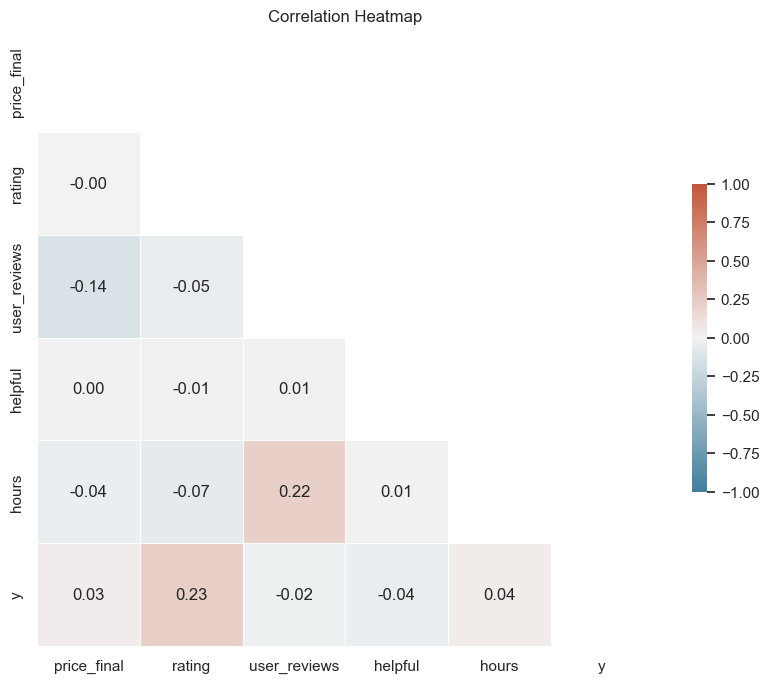

In [6]:
# correlations between different variables, such as price and rating, user reviews and helpful votes, or hours played and recommendation status.

import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


df_analyze = final_df[['price_final', 'rating', 'user_reviews', 'helpful', 'hours', 'y']]

# Convert rating column to numerical values
rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4,
    'Mostly Positive': 3,
    'Mixed': 2,
    'Mostly Negative': 1,
    'Very Negative': 0
}
df_analyze['rating'] = df_analyze['rating'].map(rating_map)

# Convert is_recommended column to binary values
df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})

# Calculate the correlation matrix
corr_matrix = df_analyze.corr()

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As expected, be observe the strongest positive correlations between is_recommended and rating and user_reviews and hours. Hours and is_recommended are also slightly correlated.
The final price seems to have a negative influence on user_reviews and the rating.

**Frequency Distribution of Final Prices**

<Figure size 1000x500 with 0 Axes>

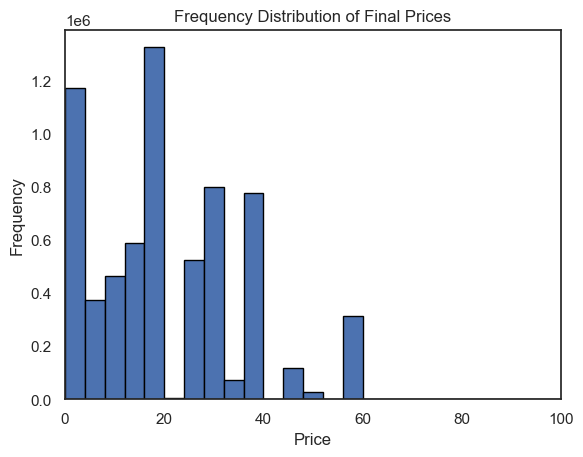

In [7]:
# frequency distribution of final prices

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.hist(final_df['price_final'], bins=25, edgecolor='black', range=(0, 100))
plt.title('Frequency Distribution of Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Set the x-axis limits to 0 and 110
plt.show()

**Boxplot of Final Prices**

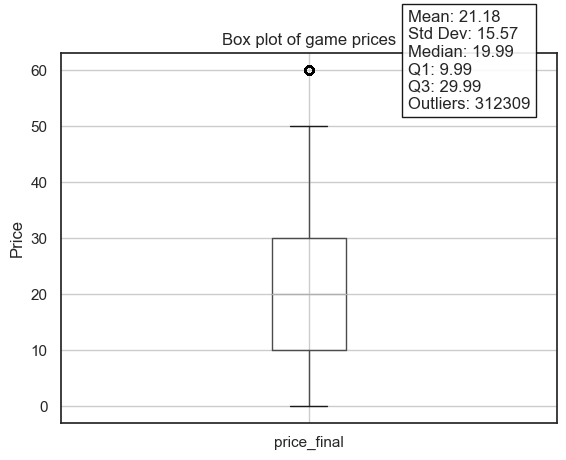

In [8]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


**Frequency Distribution of Rating**

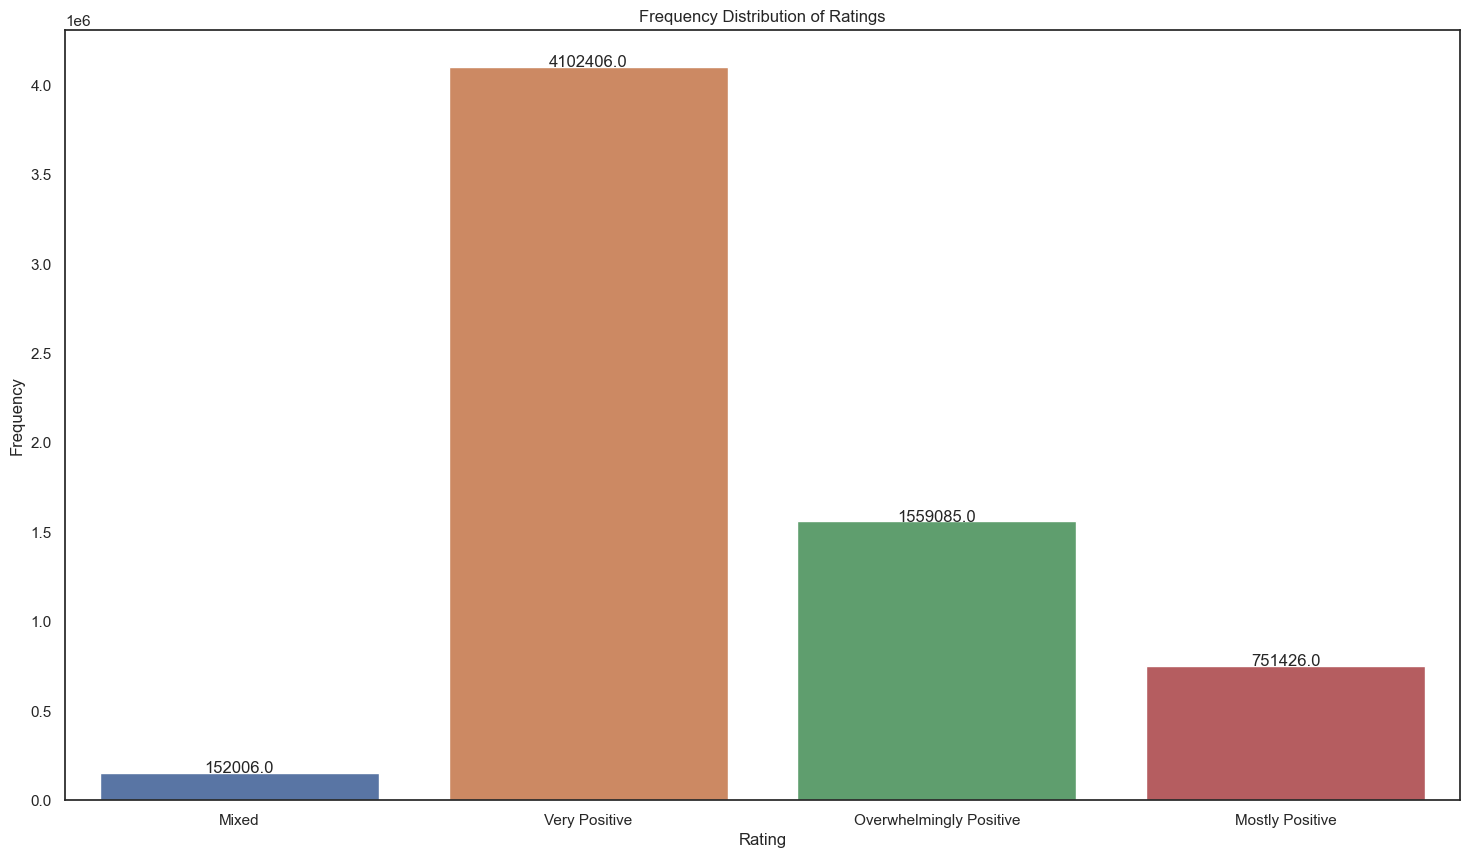

In [9]:
# Plotting the frequency distribution of rating

plt.figure(figsize=(18, 10))
ax = sns.countplot(x='rating', data=final_df)
plt.title('Frequency Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

**Frequency Distribution of Recommendations**

<Figure size 1000x500 with 0 Axes>

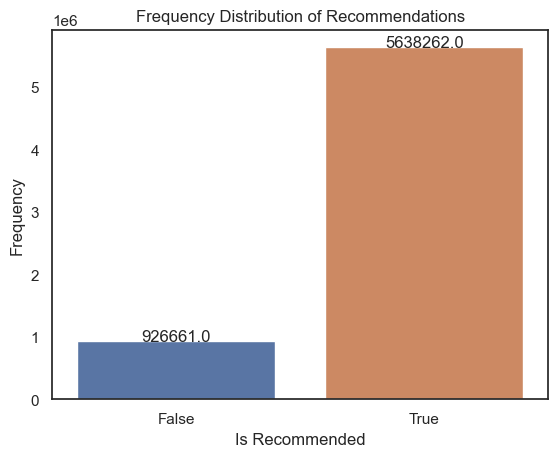

In [10]:
# Plotting the frequency distribution of number of recommendations

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
ax = sns.countplot(x='y', data=final_df)
plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is Recommended')
plt.ylabel('Frequency')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

**Compatibility of Windows, Mac and Linux**

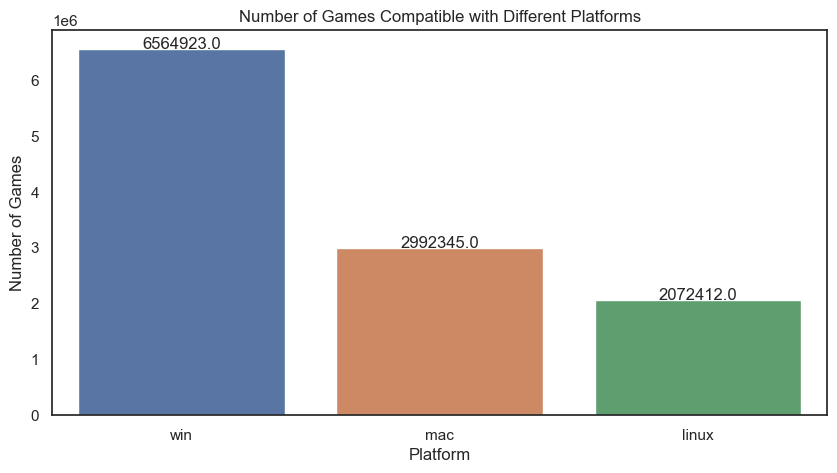

In [11]:
# compatibility with different platforms

# Calculating the number of games compatible with each platform
platform_counts = final_df[['win', 'mac', 'linux']].sum().reset_index()
platform_counts.columns = ['Platform', 'Count']

plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Platform', y='Count', data=platform_counts)
plt.title('Number of Games Compatible with Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

In [12]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

print(f"Number of games supporting only Windows: {win_only}")
print(f"Number of games supporting Windows and Mac: {win_mac}")
print(f"Number of games supporting Windows and Linux: {win_linux}")
print(f"Number of games supporting Windows, Mac, and Linux: {win_mac_linux}")
print(f"Number of games supporting only Mac: {mac_only}")
print(f"Number of games supporting only Linux: {linux_only}")

Number of games supporting only Windows: 3433718
Number of games supporting Windows and Mac: 1058793
Number of games supporting Windows and Linux: 138860
Number of games supporting Windows, Mac, and Linux: 1933552
Number of games supporting only Mac: 0
Number of games supporting only Linux: 0


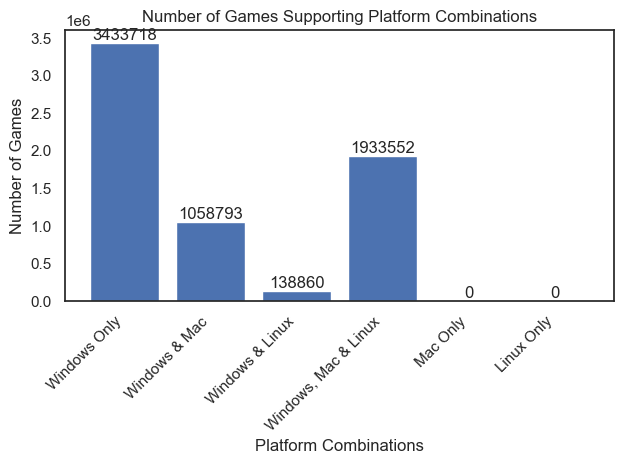

In [13]:
# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Most popular Tags**

In [14]:
import pandas as pd

# Read the data
final_df = pd.read_csv("data/final_df.csv")

# Split and count steamspy_tags and genres
steamspy_tags = final_df['steamspy_tags'].str.split(';', expand=True).stack().value_counts()
genres = final_df['genres'].str.split(';', expand=True).stack().value_counts()

# Print the most common steamspy_tags and genres
print("Most common steamspy_tags:\n", steamspy_tags.head(10))
print("\nMost common genres:\n", genres.head(10))

# Combine the split steamspy_tags and genres back into the DataFrame
final_df['steamspy_tags'] = final_df['steamspy_tags'].str.split(';')
final_df['genres'] = final_df['genres'].str.split(';')

# Calculate game popularity metrics, sales, and price_final
final_df['average_playtime'] = final_df['average_playtime'].astype(float)
final_df['reviews'] = final_df['reviews'].astype(int)
final_df['price_final'] = final_df['price_final'].astype(float)

# Group by steamspy_tags and genres, and calculate the average popularity, sales metrics, and price_final
tags_popularity = final_df.explode('steamspy_tags').groupby('steamspy_tags').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

genres_popularity = final_df.explode('genres').groupby('genres').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

# Print the popularity, sales metrics, and price_final for the most common steamspy_tags and genres
print("\nPopularity, sales metrics, and price_final by steamspy_tags:\n", tags_popularity.head(10))
print("\nPopularity, sales metrics, and price_final by genres:\n", genres_popularity.head(10))


Most common steamspy_tags:
 Multiplayer     1732486
Open World      1415637
Action           995104
Survival         946870
Early Access     826943
Strategy         756042
Simulation       738411
RPG              726357
Free to Play     705981
FPS              537184
dtype: int64

Most common genres:
 Action                   3817117
Indie                    2346579
Adventure                2102999
Simulation               1981192
RPG                      1886264
Strategy                 1544259
Massively Multiplayer    1163245
Free to Play              935916
Early Access              826943
Casual                    380103
dtype: int64

Popularity, sales metrics, and price_final by steamspy_tags:
                average_playtime  reviews  price_final
steamspy_tags                                        
Open World          4347.390175  5947646    24.043371
Multiplayer         8348.765203  5774051    17.833860
Action              2869.094935  4610032    17.975804
Survival            6

Games with the tags "multiplayer", "open world", "survival", "free to play" and "simulation" are the most popular ones based on the number of tags. 

The most popular genres are "action", "adventure", " indie", "simulation" and "RPG".

We also observe the impact of tags on game popularity and sales. 

The tags "FPS" and "multiplayer" lead to the longest average playtime. 
Games with the tags "mulitplayer" and "open world" have the most reviews. 
Games with the tags "RPG" and "Survial" have the higest final price.

Among genres, "free to play" has the highest average playtime. "Action" has the most reviews and "strategy" the highest final price.

**Trends in game releases, user reviews, and ratings over time**

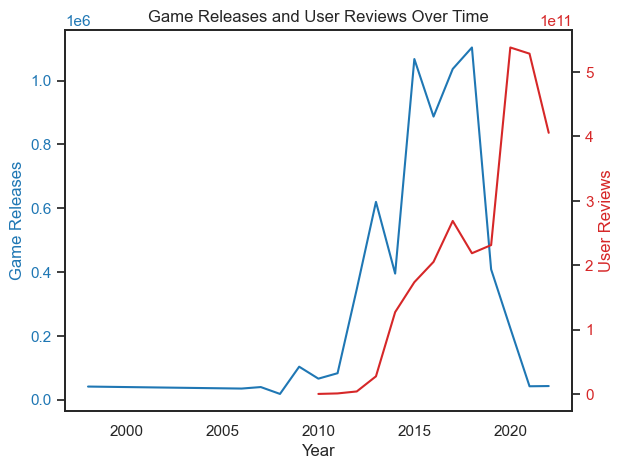

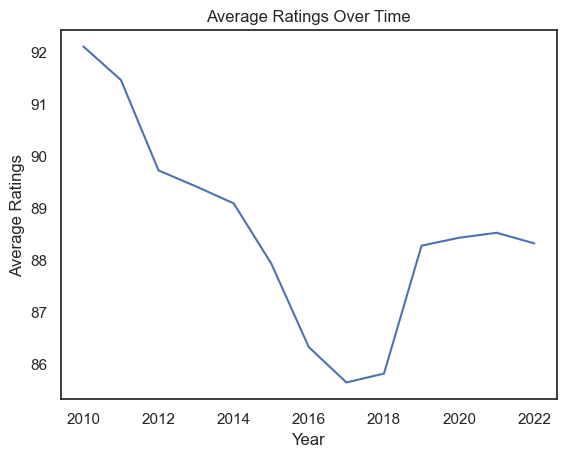

In [15]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()

On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to a rating of 84 in the year 2022. This could potentially indicate that the quality in games has also decreased and user are less satisfied with their games.

## Feature Engineering

**Elapsed Time:** A new feature which tracks the amount of time that has elapsed between the game's release and the review being logged. This could be interested because people who purchase a game right after its release are likely to be larger fans of the genre or franchise.

In [16]:
final_df["elapsed_time"] = final_df["date"] - final_df["date_release"]

**Relative Recommendation:** Find the rate at which users rated a game positively (out of the count of games they have rated). Then, find for each review whether a recommendation is in line with user's typical reviews or not.

In [17]:
# Count the number of reviews per user and rename column
usr_rating_count = final_df[["user_id","y"]].groupby("user_id").count()
usr_rating_count.rename(columns = {"y":"review_count"}, inplace = True)

# Find the number of positive reviews
usr_rating_count["positive_reviews"] = final_df[["user_id","y"]].groupby("user_id").sum()

# Find how many reviews out of total are positive
usr_rating_count["positive_rate"] = usr_rating_count["positive_reviews"] / usr_rating_count["review_count"]

In [18]:
# Merge review_count and positive_rate to the final_df
final_df = final_df.merge(usr_rating_count.reset_index()[["user_id", "review_count", "positive_rate"]], 
                          how = "left", on = "user_id")

# Use these to create an ulterior feature with recommendation relative to average recommendation
final_df["relaitve_rec"] = (final_df["y"] - final_df["positive_rate"])

**Tendency to Review:** People who review more often tend to...

In [19]:
# Find Review Tendency
final_df["review_tendency"] =  final_df["reviews"] /final_df["products"] 

# Find Tendency Relative to Median Because of Low Values
final_df["rel_review_tendency"] = (final_df["review_tendency"] - final_df["review_tendency"].median())/ final_df["review_tendency"].median()

**Positive & Negative Reviews:** Here we calculate the number of positive and negative reviews for each game. This is done through the positive_ratio column.

In [20]:
final_df["positive_reviews"] = final_df["positive_ratio"] * final_df["user_reviews"]
final_df["negative_reviews"] = (1 - final_df["positive_ratio"]) * final_df["user_reviews"]

In [21]:
final_df.head(2)

,app_id,helpful,funny,date,y,hours,user_id,review_id,title,date_release,...,products,reviews,elapsed_time,review_count,positive_rate,relaitve_rec,review_tendency,rel_review_tendency,positive_reviews,negative_reviews
0,304390,4,0,2017-02-17,False,11.5,1098,1,FOR HONOR™,2017-02-13,...,269,1,4 days,1,0.0,0.0,0.003717,-0.869888,5172828,-5096757
1,304390,2,0,2017-03-23,False,180.6,140776,26,FOR HONOR™,2017-02-13,...,110,2,38 days,2,0.0,0.0,0.018182,-0.363636,5172828,-5096757


## Final Dataset Exploration

In [22]:
# We see how many positive and negative recommendations there are
print(df_recommendations["y"].value_counts())

# What is their ratio?
print("\nHow many positive reviews for each negative one?")
df_recommendations["y"].value_counts()[0]/df_recommendations["y"].value_counts()[1]

NameError: name 'df_recommendations' is not defined

## Model Preparation

#### Logistic Regression Model

In [ ]:
# Consider balancing out data because of overwhelming positivity

## Network Analytics

In [23]:

final_df = final_df.sample(n=1000, random_state=1)

# Create a graph object
G = nx.Graph(directed=True)
# Add nodes for each unique app_id from all Games
G.add_nodes_from(df_merged_users['app_id'].unique())

# Loop over each app_id and group the user_ids
for app in df_merged_users['app_id'].unique():
    users = df_merged_users[df_merged_users['app_id'] == app]['user_id'].tolist()
    edges = [(users[i], users[j]) for i in range(len(users)) for j in range(i+1, len(users))]
    weight = len(edges)
    if weight > 800:
        G.add_edges_from(edges, weight=weight)
        

# Draw the graph with node labels and edge weights
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50)
#nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
nx.draw_networkx_edges(G, pos, edge_color='gray', width=100000000000)
plt.show()

NameError: name 'nx' is not defined

In [24]:
# Create a graph object

import itertools
G = ig.Graph(directed=True)

# Add nodes for each unique app_id from all Games
unique_app_ids = final_df['app_id'].unique()
G.add_vertices(len(unique_app_ids))

# Create a mapping of app_id to game information dictionary
app_id_to_game_info = {app_id: game_info for app_id, game_info in zip(final_df['app_id'], final_df.to_dict('records'))}

# Set the game information attribute for the vertices
G.vs["game_info"] = [app_id_to_game_info[app_id] for app_id in unique_app_ids]

# Create a mapping of app_id to vertex ID
app_id_to_vertex_id = {app_id: idx for idx, app_id in enumerate(unique_app_ids)}

# Loop over each app_id and group the user_ids
for app in unique_app_ids:
    users = final_df[final_df['app_id'] == app]['user_id'].tolist()
    user_pairs = [(users[i], users[j]) for i in range(len(users)) for j in range(i+1, len(users))]
    
    # Get the unique app_ids associated with each user pair
    edges = []
    for user1, user2 in user_pairs:
        user1_apps = final_df[final_df['user_id'] == user1]['app_id'].unique()
        user2_apps = final_df[final_df['user_id'] == user2]['app_id'].unique()
        common_app_ids = list(set(user1_apps) & set(user2_apps))
        
        # Map the app_id to vertex ID
        edges.extend([(app_id_to_vertex_id[app1], app_id_to_vertex_id[app2]) for app1, app2 in itertools.combinations(common_app_ids, 2)])

In [25]:
# Degree
degree = G.degree()

# Betweenness Centrality
betweenness = G.betweenness(directed=True)

# Closeness Centrality
closeness = G.closeness(normalized=True)

# Eigenvector Centrality
eigenvector_centrality = G.eigenvector_centrality(directed=True)

# Clustering Coefficient
clustering_coefficient = G.transitivity_local_undirected(mode="nan")

# Diameter
diameter = G.diameter(directed=True)

# Average Path Length
average_path_length = G.average_path_length(directed=True)


In [26]:
# Extract graph features
features_df = pd.DataFrame({
    'app_id': [game_info['app_id'] for game_info in G.vs['game_info']],
    'degree': G.degree(),
    'betweenness': G.betweenness(directed=True),
    'closeness': G.closeness(normalized=True),
    'eigenvector_centrality': G.eigenvector_centrality(directed=True),
    'clustering_coefficient': G.transitivity_local_undirected(mode="nan"),
})
# Merge with the original node attributes
features_df = features_df.merge(final_df.drop_duplicates(subset='app_id'), on='app_id', how='left')


In [ ]:
# Preprocessing
# Encoding categorical variables
features_df['rating'] = pd.Categorical(features_df['rating']).codes

# Scaling numerical variables
numerical_columns = ['degree', 'betweenness', 'closeness', 'eigenvector_centrality',
                     'clustering_coefficient', 'positive_ratio', 'user_reviews',
                     'price_final', 'price_original', 'discount']
scaler = StandardScaler()
features_df[numerical_columns] = scaler.fit_transform(features_df[numerical_columns])

# Handling missing values (if any)
features_df.fillna(0, inplace=True)

# Clustering
k = 5  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df[numerical_columns])

# Prediction
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = features_df.drop(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'steam_deck', 'description', 'tags', 'is_recommended'], axis=1)
y = features_df['is_recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Prediction
y_pred = rf_clf.predict(X_test)

# Evaluate the prediction performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

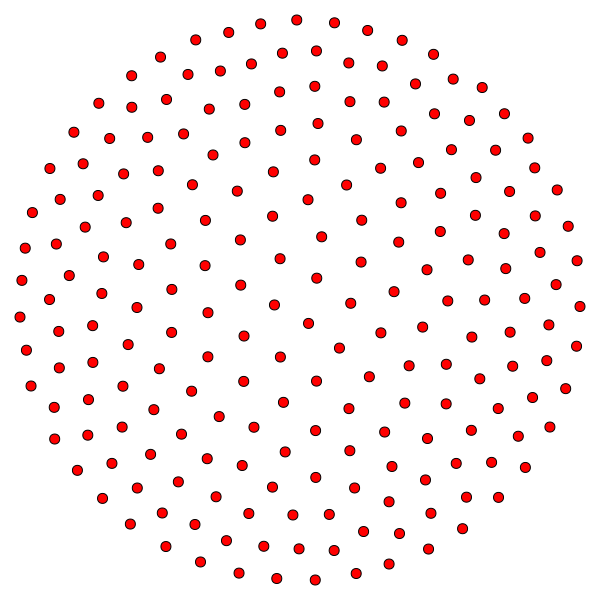

In [29]:
# Set the weight of each edge
G.es['weight'] = [G.degree(e.source) + G.degree(e.target) for e in G.es]

# Draw the graph with node labels and edge weights
visual_style = {'vertex_size': 10, 'edge_color': 'gray', 'edge_width': G.es['weight']}
ig.plot(G, **visual_style)